<a href="https://colab.research.google.com/github/leoazeved0/mvp_puc_rio/blob/main/Deep_Learning_Abelha_e_Formiga_Classifica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Objetivo**

O problema que escolhi para resolver é de visão computacional.

Usei o "Hymenoptera dataset", sendo a ordem Hymenoptera (himenópteros) um dos maiores grupos entre os insetos, compreendendo as vespas, abelhas e formigas.

A base de dados contém um total de 193 imagens de formigas e 204 de abelhas, que serão separadas em treino, teste e validação.

Este projeto tem como objetivo principal conseguir o melhor índice de reconhecimento possível das imagens, distinguindo-as entre abelhas e formigas.

Para este trabalho a deep residual learning para reconhecimento de imagem escolhida foi a Resnet18.

##Imports das bibliotecas e download

In [ ]:
!pip install gdown
import gdown
import os
import zipfile

In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
import requests
import pandas as pd
from io import BytesIO
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import pickle
cudnn.benchmark = True
import seaborn as sn


In [ ]:
file_id = "1wGjaVZ15NviFHPXHyX5pNWa6vyD0v856"
url = f"https://drive.google.com/uc?id={file_id}"

folder_path = "./dataset"  # especifique a pasta onde baixara o arquivo
os.makedirs(folder_path, exist_ok=True) # cria a pasta de destino se necessário

output = "dataset/train.zip"  # especifique o nome do arquivo e a extensão do mesmo
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1wGjaVZ15NviFHPXHyX5pNWa6vyD0v856
To: /content/dataset/train.zip
100%|██████████| 47.3M/47.3M [00:00<00:00, 161MB/s]


'dataset/train.zip'

In [ ]:
destination = 'dataset/' # path onde se encontra o arquivo 'train.zip'

os.makedirs(destination,exist_ok=True) # cria a pasta de destino se necessário

with zipfile.ZipFile(output,'r') as zip_ref:
    zip_ref.extractall(destination)

## Datasets das Imagens

In [ ]:
img_train_dataset = torchvision.datasets.ImageFolder(root='/content/dataset/hymenoptera_data/train/')
img_valid_dataset = torchvision.datasets.ImageFolder(root='/content/dataset/hymenoptera_data/val/')

Renomeando as categorias

In [ ]:
categories = ['formiga', 'abelha']

Função para visualizar imagem

In [ ]:
#pause_time = 0.0005  # seconds between frames
# Função para visualização de imagens
def visualizar_img_dataset(dataset, istensor=False):
  figure = plt.figure(figsize=(15, 9))
  rows, cols = 3, 5
  for i in range(1, 11):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    #display.display(plt.gcf())
    #display.clear_output(wait=True)
    #time.sleep(pause_time)
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(categories[label])
    plt.axis('on')
    if istensor:
      plt.imshow(img.squeeze().permute(1, 2 , 0))
    else:
      plt.imshow(img)


plt.show()


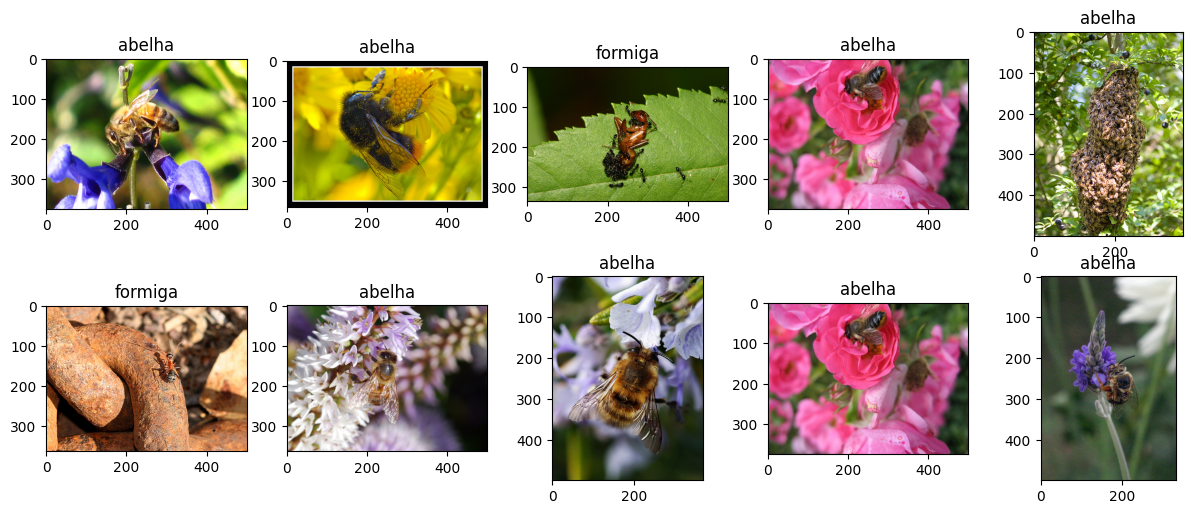

In [ ]:
# Visualizar algumas imagens
visualizar_img_dataset(img_train_dataset)

##**Pré-processamento dos dados**

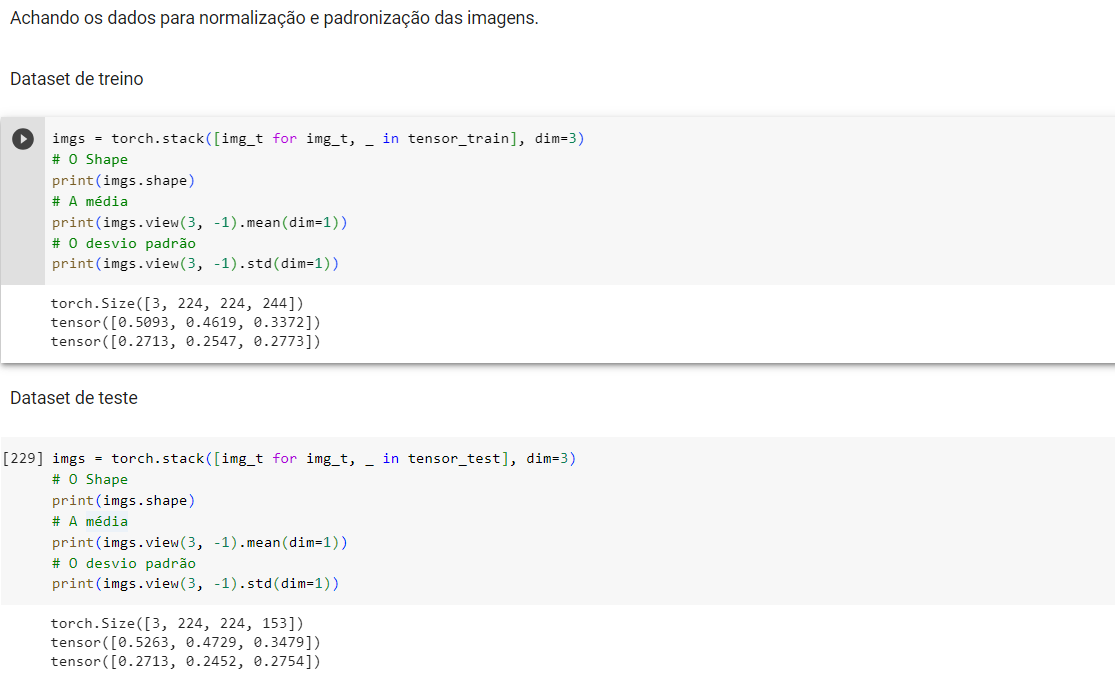

**Aplicando a normalização com os valores encontrados.**

In [ ]:
prep_transform_train = T.Compose(
    [
       T.RandomResizedCrop(224),
       T.RandomHorizontalFlip(),
       T.ToTensor(),
       T.Normalize(
          (0.5093, 0.4619, 0.3372),
          (0.2713, 0.2547, 0.2773)
       )

    ]
)

prep_transform_test = T.Compose(
    [
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(
            (0.5263, 0.4729, 0.3479),
            (0.2713, 0.2452, 0.2754)
        )

    ]
)



ds_img_train=torchvision.datasets.ImageFolder(root='/content/dataset/hymenoptera_data/train/',
                                              transform=prep_transform_train)
ds_img_val=torchvision.datasets.ImageFolder(root='/content/dataset/hymenoptera_data/val/',
                                              transform=prep_transform_test)

In [ ]:
ds_img_train

Dataset ImageFolder
    Number of datapoints: 244
    Root location: /content/dataset/hymenoptera_data/train/
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5093, 0.4619, 0.3372), std=(0.2713, 0.2547, 0.2773))
           )

In [ ]:
ds_img_val

Dataset ImageFolder
    Number of datapoints: 153
    Root location: /content/dataset/hymenoptera_data/val/
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.5263, 0.4729, 0.3479), std=(0.2713, 0.2452, 0.2754))
           )

Preparando os dados para treino, teste e validação com DataLoaders

In [ ]:
ds_img_train, ds_img_test = torch.utils.data.random_split(ds_img_train, [171, 73])

In [ ]:
bath_size = 64

train_loader = DataLoader(
    ds_img_train, batch_size=bath_size, shuffle=True,
    num_workers=2
)
test_loader = DataLoader(
    ds_img_train, batch_size=bath_size, shuffle=True,
    num_workers=2
)
val_loader = DataLoader(
    ds_img_val, batch_size=bath_size, shuffle=True,
    num_workers=2
)

**Visualização de algumas imagens de treino com a normalização aplicada**

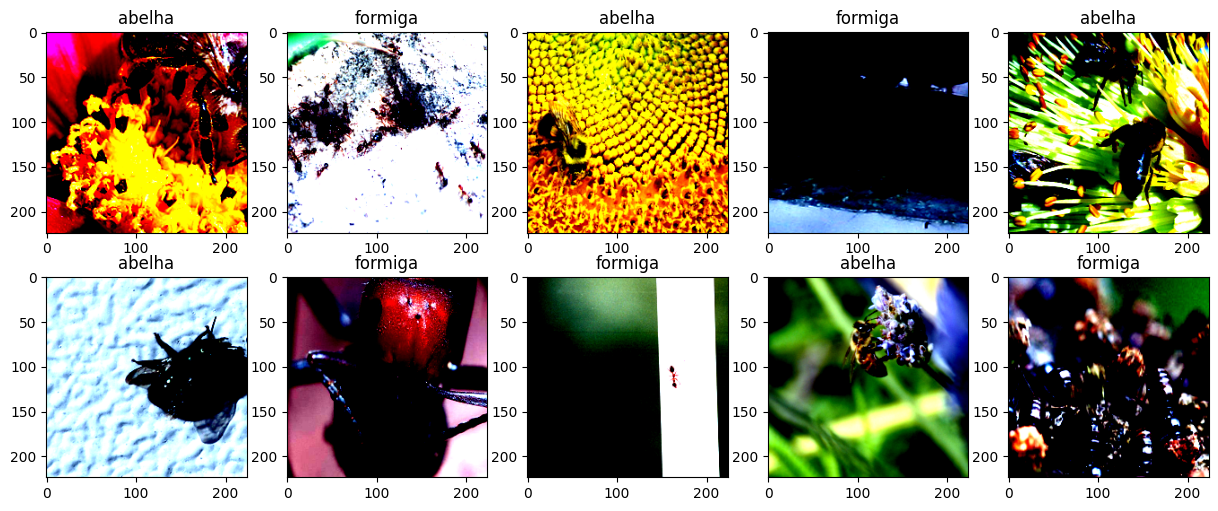

In [ ]:
visualizar_img_dataset(ds_img_train, True)

**Visualização de algumas imagens de teste com a normalização aplicada**

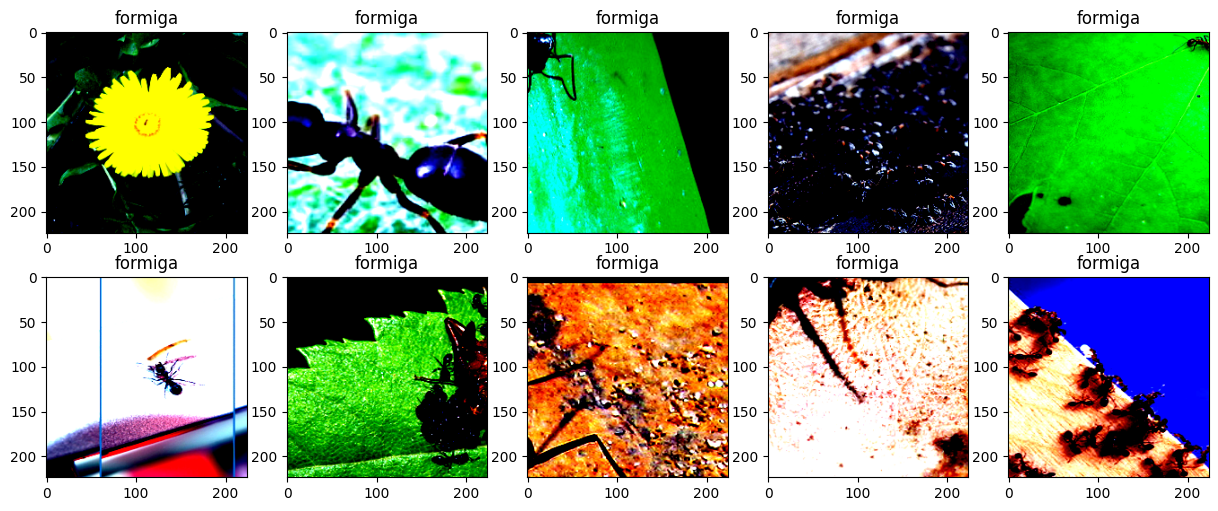

In [ ]:
visualizar_img_dataset(ds_img_test, True)

##Device

is_available() para determinar se o seu sistema suporta CUDA.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Rodando na {device}')

Rodando na cuda


## Funções

In [ ]:
# treinamento
def train(model, dataloader, lossfunc, optimizer):
  model.train()
  cumloss = 0.0

  for imgs, labels in dataloader:

    imgs, labels = imgs.to(device), labels.to(device)
    pred = model(imgs)
    loss = lossfunc(pred, labels)

    # zera os gradiente acumulados
    optimizer.zero_grad()
    # computa os gradiente
    loss.backward()
    # anda para a direção que reduz o erro local
    optimizer.step()
    # loss é um tensor; item para obter o float
    cumloss += loss.item()

  return cumloss / len(dataloader)
# validação
def validate(model, dataloader, lossfunc):
  model.eval()
  cumloss = 0.0
  with torch.no_grad():
   for imgs, labels in dataloader:
     imgs, labels = imgs.to(device), labels.to(device)
     pred = model(imgs)
     loss = lossfunc(pred, labels)
     cumloss += loss.item()
  return cumloss / len(dataloader)


In [ ]:
# função para plotar as perdas
def plot_losses(losses):
  fig = plt.figure(figsize=(8, 6))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="14")
  ax.set_xlabel("Iteration", fontsize="14")
  ax.set_ylabel("Loss", fontsize="14")
  ax.set_title("Loss vs iterations", fontsize="14");

In [ ]:
# função matriz de confusão
def make_confusion_matrix(model, loader, n_classes):
  confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int64)
  with torch.no_grad():
    for i, (imgs, labels) in enumerate(loader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      _, predicted = torch.max(outputs, 1)
      for t, p in zip(torch.as_tensor(labels, dtype=torch.int64).view(-1),
                        torch.as_tensor(predicted, dtype=torch.int64).view(-1)):
        confusion_matrix[t,p] += 1
  return confusion_matrix

# função acurácia
def evaluate_accuracy(model, dataloader, classes, verbose = True):
  # prepare to count predictions for each class
  correct_pred = {classname:0 for classname in classes}
  total_pred = {classname:0 for classname in classes}
  confusion_matrix = make_confusion_matrix(model, dataloader, len(classes))
  if verbose:
    total_correct = 0.0
    total_prediction = 0.0
    for i, classname in enumerate(classes):
      correct_count = confusion_matrix[i][i].item()
      class_pred = torch.sum(confusion_matrix[i]).item()

      total_correct += correct_count
      total_prediction += class_pred

      accuracy = 100 * float(correct_count) / class_pred
      print('Accuracy for class {:5s} is {:.3f}%' .format(classname,
                                                          accuracy))
  print('Global accuracy is {:.3f}%'.format(100 * total_correct/total_prediction))
  return confusion_matrix


##Modelo

Aqui utilizarei a Resnet18 com o carregamento do pré-treino IMAGENET1K_V1.

Uma das principais razões pelas quais optei pelo ResNet-18 em vez do ResNet-50 é o tamanho do conjunto de dados que usei. O conjunto de dados é relativamente pequeno em comparação com os milhões de imagens usadas para treinar modelos como ResNet-50 no conjunto de dados ImageNet. O ResNet-50, sendo uma rede mais profunda e complexa, é propenso a overfitting quando treinado em dados limitados. Por outro lado, o ResNet-18 consegue um equilíbrio entre a capacidade do modelo e a eficiência computacional, tornando-o mais adequado para conjuntos de dados menores. Fiz uma pequena mudança na arquitetura do modelo resnet18 para a tarefa de classificação binária.

In [ ]:
conv_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in conv_model.parameters():
    param.requires_grad = False

num_ftrs = conv_model.fc.in_features

conv_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256 ),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(256 , 64),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(64 , 2)
)

conv_model = conv_model.to(device)

conv_lossfunc = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
conv_optimizer = optim.SGD(conv_model.fc.parameters(), lr=0.001, momentum=0.9)

In [ ]:
summary(conv_model, (3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

##Treinamento da rede

In [ ]:
epochs = 250
train_losses = []
test_losses = []

local_save_model = "./dataset/modelo_salvo/"  # especifica a pasta onde baixar o arquivo
os.makedirs(local_save_model, exist_ok=True) # cria a pasta de destino se necessário

best_model_params_path = os.path.join(local_save_model, 'best_model_params.pth')
torch.save(conv_model.state_dict(), best_model_params_path)
best_loss = 100.0
since = time.time()

for t in range(epochs):
      train_loss = train(conv_model, train_loader, conv_lossfunc, conv_optimizer)
      train_losses.append(train_loss)
      test_loss = validate(conv_model, test_loader, conv_lossfunc)
      test_losses.append(test_loss)
      #if  t % 10 == 0:
      print(f'Epoch: {t} / Train Loss: {train_loss:.5f} and Test Loss: {test_loss:.5f}')

      if best_loss > test_loss:
        best_loss = test_loss
        torch.save(conv_model.state_dict(), best_model_params_path) # salva o melhor modelo conforme o melhor loss no teste de validação.

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Loss: {best_loss:.5f}')


Epoch: 0 / Train Loss: 0.72207 and Test Loss: 0.71075
Epoch: 1 / Train Loss: 0.72271 and Test Loss: 0.70500
Epoch: 2 / Train Loss: 0.70934 and Test Loss: 0.69781
Epoch: 3 / Train Loss: 0.70640 and Test Loss: 0.68972
Epoch: 4 / Train Loss: 0.68766 and Test Loss: 0.68426
Epoch: 5 / Train Loss: 0.69192 and Test Loss: 0.67722
Epoch: 6 / Train Loss: 0.68776 and Test Loss: 0.67957
Epoch: 7 / Train Loss: 0.67757 and Test Loss: 0.67322
Epoch: 8 / Train Loss: 0.67600 and Test Loss: 0.67329
Epoch: 9 / Train Loss: 0.66689 and Test Loss: 0.66467
Epoch: 10 / Train Loss: 0.66092 and Test Loss: 0.66109
Epoch: 11 / Train Loss: 0.67319 and Test Loss: 0.66109
Epoch: 12 / Train Loss: 0.66576 and Test Loss: 0.65565
Epoch: 13 / Train Loss: 0.65565 and Test Loss: 0.65130
Epoch: 14 / Train Loss: 0.64847 and Test Loss: 0.65066
Epoch: 15 / Train Loss: 0.65590 and Test Loss: 0.64726
Epoch: 16 / Train Loss: 0.64734 and Test Loss: 0.63576
Epoch: 17 / Train Loss: 0.63332 and Test Loss: 0.63623
Epoch: 18 / Train Lo

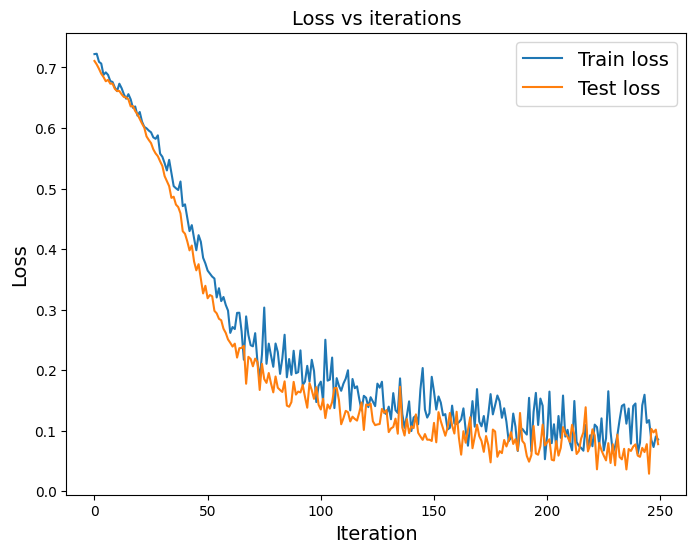

In [ ]:
# plotando Train Loss e Test Loss
conv_losses = {"Train loss": train_losses,"Test loss": test_losses }
plot_losses(conv_losses)

##Validação com dados não vistos

Carregando o modelo do google drive que eu já treinei para validar.

In [58]:
file_id = "1O-WIhJaaxYqE0wsOip-4kqRipW-ayfCv"
url = f"https://drive.google.com/uc?id={file_id}"

folder_path = "./dataset/modelo_salvo/treinado/"  # especifique a pasta onde baixara o arquivo
os.makedirs(folder_path, exist_ok=True) # cria a pasta de destino se necessário

output = "./dataset/modelo_salvo/treinado/melhor_modelo_treinado.pth"  # especifique o nome do arquivo e a extensão do mesmo
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1O-WIhJaaxYqE0wsOip-4kqRipW-ayfCv
To: /content/dataset/modelo_salvo/treinado/melhor_modelo_treinado.pth
100%|██████████| 45.4M/45.4M [00:00<00:00, 185MB/s]


'./dataset/modelo_salvo/treinado/melhor_modelo_treinado.pth'

In [59]:
local_save_model = "/content/dataset/modelo_salvo/treinado/"  # especifica a pasta onde baixar o arquivo
os.makedirs(local_save_model, exist_ok=True) # cria a pasta de destino se necessário

down_best_model_params_path = os.path.join(local_save_model, 'melhor_modelo_treinado.pth')

Validando com os parâmetros carregados.

In [71]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Rodando na {device}')

new_model = torchvision.models.resnet18()
for param in new_model.parameters():
    param.requires_grad = False
num_ftrs = new_model.fc.in_features

new_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256 ),
    nn.ReLU(),
    nn.Dropout( 0.25 ),
    nn.Linear( 256 , 64 ),
    nn.ReLU(),
    nn.Dropout( 0.25 ),
    nn.Linear( 64 , 2 )
)
new_model.eval()
new_model = new_model.to(device)
new_model.load_state_dict(torch.load(down_best_model_params_path, map_location=torch.device(device))) # load best model weights
confusion_matrix = evaluate_accuracy(new_model, val_loader, categories) #usando o dataset val_loader de validação com imagens diferentes do treinamento e do teste


Rodando na cpu
Accuracy for class formiga is 97.143%
Accuracy for class abelha is 92.771%
Global accuracy is 94.771%


<Axes: >

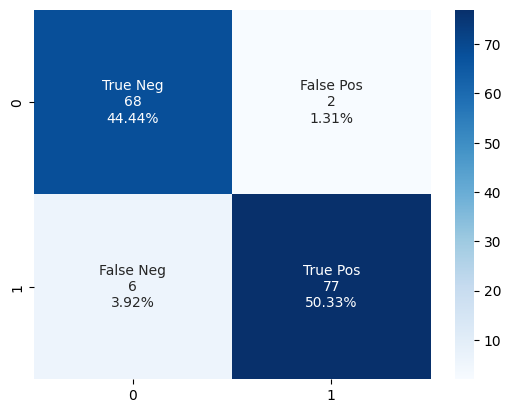

In [72]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     confusion_matrix.flatten()/sum(confusion_matrix.flatten())]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sn.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')

Uma foto não vista nem no treino e nem na validação

In [73]:
file_id = "16tMmacSHPh3ZK7PkmO4dE4LwAZYzZqJc"
url = f"https://drive.google.com/uc?id={file_id}"

folder_path = "./dataset"  # especifique a pasta onde baixara o arquivo
os.makedirs(folder_path, exist_ok=True) # cria a pasta de destino se necessário

output = "dataset/abelha_validacao.zip"  # especifique o nome do arquivo e a extensão do mesmo
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=16tMmacSHPh3ZK7PkmO4dE4LwAZYzZqJc
To: /content/dataset/abelha_validacao.zip
100%|██████████| 69.2k/69.2k [00:00<00:00, 57.9MB/s]


'dataset/abelha_validacao.zip'

In [74]:
destination = 'dataset/abelha' # path onde se encontra o arquivo 'train.zip'

os.makedirs(destination,exist_ok=True) # cria a pasta de destino se necessário

with zipfile.ZipFile(output,'r') as zip_ref:
    zip_ref.extractall(destination)

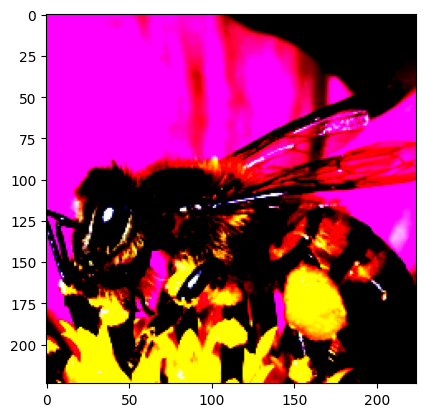

In [75]:
img = Image.open('/content/dataset/abelha/abelha.jpg')

img_tensor = prep_transform_test(img)
plt.imshow(img_tensor.squeeze().permute(1, 2 , 0))
batch = img_tensor.unsqueeze(0).to(device)
new_conv_avaliacao = new_model(batch)


formiga probability: 0.15%
abelha probability: 99.85%


<Axes: >

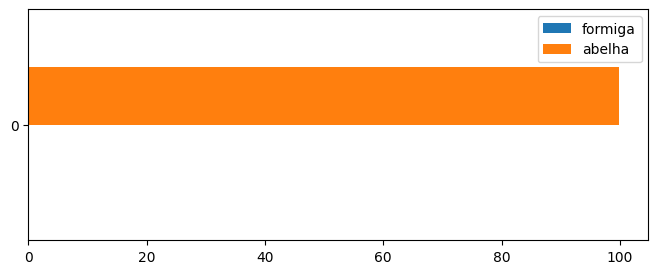

In [76]:
probs = torch.nn.functional.softmax(new_conv_avaliacao, dim=1) * 100
prob_dict = {}
for i, classname in enumerate(categories):
  prob = probs[0][i].item()
  print(f'{classname} probability: {prob:.2f}%')
  prob_dict[classname] = [prob]

df_prob = pd.DataFrame.from_dict(prob_dict)

df_prob.plot(kind ='barh', figsize=(8,3))

##**Conclusão**

Depois de um treinamento de 250 épocas, foi salvo o treinamento que melhor se saiu avaliando o dataset de teste, e o critério usado foi o que obteve o menor "Loss" no reconhecimento do conjunto de teste.

Não foi identificado Overfitting no modelo treinado.

Salvei este modelo para utilizá-lo em um conjunto de imagens ainda não visto pelo modelo, e de 153 imagens não conhecidas, o reconhecimento foi de mais de 94,7% do total, representando 97,1% para imagens de formigas e 92,7% para as de abelhas.

Para fins de redundância, testei novamente com uma imagem de abelha não presente em nenhum dos conjuntos usados, e o modelo apresentou uma probabilidade de mais de 99%, prevendo corretamente a classe da imagem.

Este modelo se apresentou muito eficaz no reconhecimento de imagens dos insetos escolhidos, alcançando o meu objetivo incicial, obtendo um índice de acerto bem expressivo.


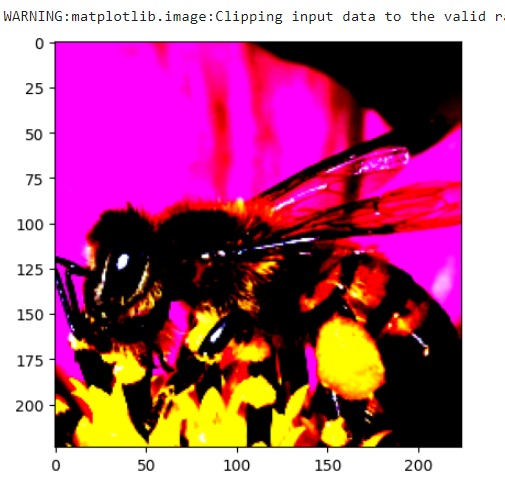

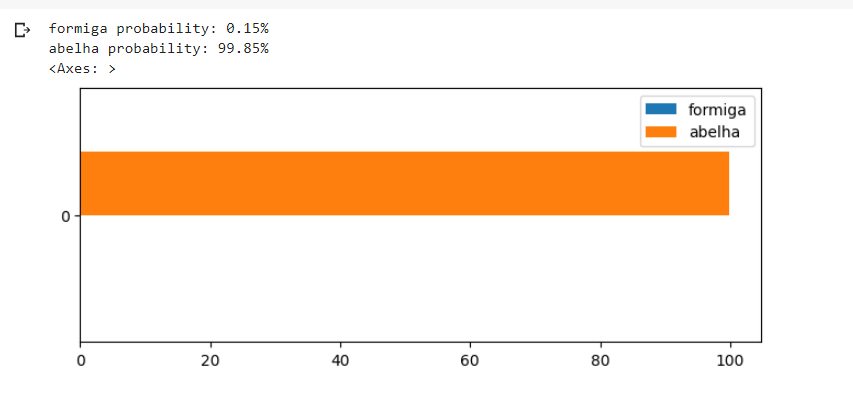